# Machine Learning Impied Volatility

This notebook focuses on estimating **implied volatility (IV)** using **machine learning regression models**.  
By leveraging market option data, we train neural networks to learn the mapping between observable option parameters—such as **spot price**, **strike**, **maturity**, **interest rate**, and **option price**—and the corresponding **implied volatility** computed via the **Black–Scholes framework**.

The workflow involves:
1. Fetching or generating option data using `DataFetcher` and computing ground-truth IVs via `ImpliedVolCalculator`.
2. Preprocessing and scaling the features for neural network training.
3. Training and evaluating ML models to approximate the nonlinear inverse of the Black–Scholes pricing function.
4. Analysing feature importance to understand which inputs most affect implied volatility prediction accuracy.

This approach demonstrates how machine learning can serve as a fast, flexible alternative to iterative numerical methods for IV estimation.


# Import Libraries

In [1]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score



import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent / "src"))
from implied_vol import DataFetcher, ImpliedVolCalculator

# Data Collection and Implied Volatility Computation

We begin by retrieving **S&P 500 (SPX)** option data using the `DataFetcher` class, selecting the first few available expiry dates and collecting data over a 15-day window.  
The **ImpliedVolCalculator** is then used to compute the implied volatility for each option record based on the **Black–Scholes model**, assuming a constant risk-free rate of 5%.

This process yields a dataset containing option parameters and their corresponding implied volatilities, which will serve as the ground truth for subsequent machine learning regression and prediction tasks.


In [2]:
fetcher = DataFetcher("^SPX")
expiries = fetcher.stock.options[:3]   
raw_df = fetcher.get_multi_day_data(expiries, days=15)

iv_calc = ImpliedVolCalculator(r=0.05)
iv_df = iv_calc.compute_for_dataframe(raw_df)

print(iv_df.head())
print(f"Total samples: {len(iv_df)}")



    strike  lastPrice        date      expiry         spot         T  \
1   3000.0    3698.50  2025-09-30  2025-10-20  6688.459961  0.054795   
26  6280.0     444.11  2025-09-30  2025-10-20  6688.459961  0.054795   
27  6290.0     434.29  2025-09-30  2025-10-20  6688.459961  0.054795   
98  6675.0      32.02  2025-09-30  2025-10-20  6688.459961  0.054795   
99  6680.0      27.40  2025-09-30  2025-10-20  6688.459961  0.054795   

          iv  moneyness  
1   1.309090   0.448534  
26  0.229169   0.938931  
27  0.225660   0.940426  
98  0.011637   0.997988  
99  0.012064   0.998735  
Total samples: 3735


# Volatility Smiles by Expiry

The plot illustrates the **volatility smile** for multiple option expiry dates, showing how **implied volatility (IV)** varies with **moneyness (K/S)**.  
Each curve corresponds to a different expiry, revealing the characteristic U-shaped pattern:  
options that are **deep in** or **out of the money** exhibit higher implied volatilities, while those **near the money** tend to have lower IV values.  

This behaviour reflects market expectations of asymmetric risk and volatility skew across maturities.


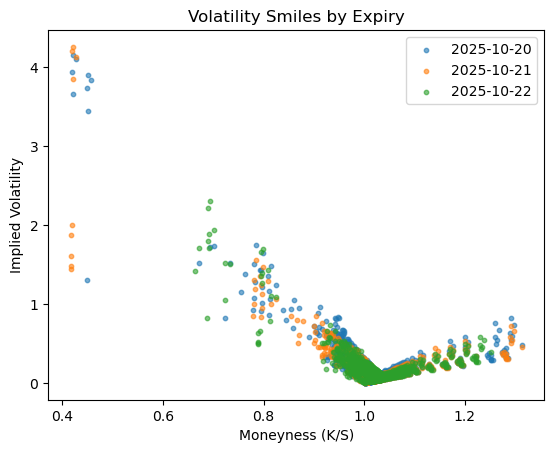

In [3]:
for expiry, group in iv_df.groupby('expiry'):
    plt.scatter(group['moneyness'], group['iv'], s=10, label=expiry, alpha=0.6)

plt.xlabel('Moneyness (K/S)')
plt.ylabel('Implied Volatility')
plt.title('Volatility Smiles by Expiry')
plt.legend()
plt.show()


# Separate Test and Train data
We are going to split the data so that 2 of the dates will train the NN to predict the 3rd date which it will not have seen

In [4]:
train_expiries = ['2025-10-20', '2025-10-21']
test_expiry    = '2025-10-22'

train_df = iv_df[iv_df['expiry'].isin(train_expiries)].copy()
test_df  = iv_df[iv_df['expiry'] == test_expiry].copy()

print(len(train_df), "train samples,", len(test_df), "test samples")


2503 train samples, 1232 test samples


In [5]:

X_train = train_df[['moneyness', 'T']].values
y_train = train_df['iv'].values
X_test  = test_df[['moneyness', 'T']].values
y_test  = test_df['iv'].values

In [6]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [7]:


ml_model = MLPRegressor(hidden_layer_sizes=(64,64),
                        activation='tanh',
                        alpha=1e-3,
                        max_iter=2500,
                        random_state=42)

ml_model.fit(X_train_scaled, y_train)
y_pred = ml_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test Expiry {test_expiry}: RMSE={rmse:.4f}, R²={r2:.4f}")


Test Expiry 2025-10-22: RMSE=0.0758, R²=0.8778


# Predicted vs Market Volatility Smile

This plot compares the **machine learning model’s predicted implied volatilities** against the **market-observed values** for an unseen option expiry.  
Both are plotted as a function of **moneyness (K/S)** to visualise how well the trained model generalises beyond the training data.

Good alignment between the two curves indicates that the model successfully captures the shape and level of the **volatility smile**, demonstrating its effectiveness in approximating the market’s implied volatility surface.


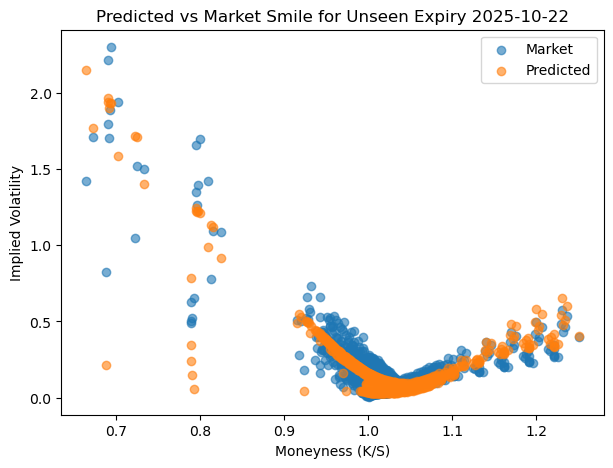

In [8]:

plt.figure(figsize=(7,5))
plt.scatter(test_df['moneyness'], y_test, label='Market', alpha=0.6)
plt.scatter(test_df['moneyness'], y_pred, label='Predicted', alpha=0.6)
plt.xlabel("Moneyness (K/S)")
plt.ylabel("Implied Volatility")
plt.title(f"Predicted vs Market Smile for Unseen Expiry {test_expiry}")
plt.legend()
plt.show()


# Neural Network-Predicted Volatility Smile

To visualise the model’s learned behaviour, the neural network’s predicted **implied volatility** is plotted as a smooth function of **moneyness (K/S)** at a fixed average maturity.  
Market data points are shown for comparison.

The resulting **predicted smile** (orange curve) demonstrates the network’s ability to capture the continuous, nonlinear relationship between moneyness and implied volatility — reflecting the characteristic smile or skew shape observed in real markets.


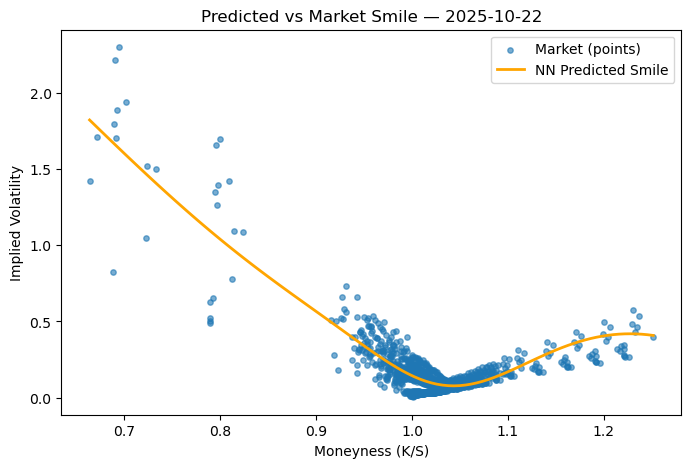

In [9]:
# Sort by moneyness for plotting
order = np.argsort(test_df["moneyness"].values)
X_sorted = X_test[order]
y_true_sorted = y_test[order]
y_pred_sorted = y_pred[order]

# Generate a smooth grid in moneyness (fixed T)
T_fixed = np.mean(test_df["T"])
m_grid = np.linspace(min(test_df["moneyness"]), max(test_df["moneyness"]), 100)
X_grid = np.column_stack([m_grid, np.full_like(m_grid, T_fixed)])
X_grid_scaled = scaler.transform(X_grid)
y_grid_pred = ml_model.predict(X_grid_scaled)

plt.figure(figsize=(8,5))
plt.scatter(test_df["moneyness"], y_test, s=15, alpha=0.6, label="Market (points)")
plt.plot(m_grid, y_grid_pred, color="orange", lw=2.0, label="NN Predicted Smile")
plt.xlabel("Moneyness (K/S)")
plt.ylabel("Implied Volatility")
plt.title(f"Predicted vs Market Smile — {test_expiry}")
plt.legend()
plt.show()


# Feature Importance Analysis

Permutation importance is computed on the test set to quantify how each input feature influences the neural network’s implied volatility predictions.  
By measuring the decrease in **R² score** when each feature is randomly shuffled, we assess its contribution to model accuracy.

The results indicate the relative importance of **moneyness (K/S)** and **time-to-maturity (T)** in shaping the implied volatility surface, providing insight into which variables the model relies on most when reconstructing the market’s volatility structure.


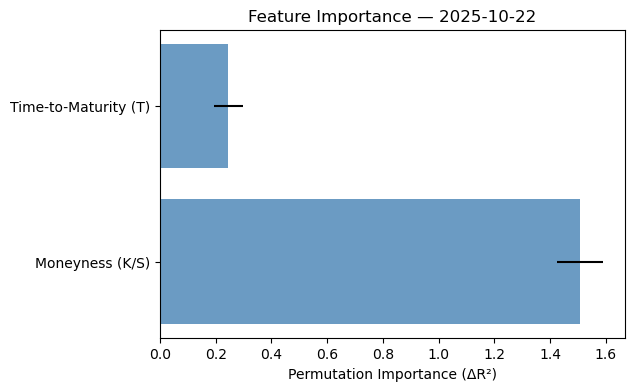

Feature Importances (ΔR²):
Moneyness (K/S): 1.5058
Time-to-Maturity (T): 0.2445


In [10]:
# Compute permutation importance on the test set
r = permutation_importance(
    ml_model, 
    X_test_scaled, 
    y_test, 
    n_repeats=20,
    random_state=42,
    scoring="r2"
)

# Extract mean and std for each feature
feature_names = ["Moneyness (K/S)", "Time-to-Maturity (T)"]
importances = r.importances_mean
stds = r.importances_std

# Plot results
plt.figure(figsize=(6,4))
plt.barh(feature_names, importances, xerr=stds, color='steelblue', alpha=0.8)
plt.xlabel("Permutation Importance (ΔR²)")
plt.title(f"Feature Importance — {test_expiry}")
plt.show()

print("Feature Importances (ΔR²):")
for name, val in zip(feature_names, importances):
    print(f"{name}: {val:.4f}")
